In [188]:
'''

USGS (US Geological Survey) publishes earthquake data. Here’s a feed spanning all domestic earthquakes from the past month:
https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson

Using this JSON feed:
1) identify every earthquake in California from past month,
2) list them by increasing magnitude
3. and finally output in a format resembling the following e.g.:

2017-07-13T22:32:48+00:00 | 15km SE of Mammoth Lakes, California | Magnitude: 0.92
2017-07-13T22:49:58+00:00 | 8km ENE of Mammoth Lakes, California | Magnitude: 0.92
2017-07-13T22:37:52+00:00 | 12km E of Mammoth Lakes, California | Magnitude: 0.95
2017-07-13T20:43:37+00:00 | 3km NW of Greenville, California | Magnitude: 1
2017-07-13T22:31:04+00:00 | 11km E of Mammoth Lakes, California | Magnitude: 1.31
2017-07-13T22:45:28+00:00 | 37km SE of Bridgeport, California | Magnitude: 1.7
2017-07-13T22:54:30+00:00 | 3km SE of Atascadero, California | Magnitude: 2.04
2017-07-13T22:09:53+00:00 | 41km SW of Ferndale, California | Magnitude: 2.76

'''

In [1]:
import json
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

In [13]:
filename = './all_month.geojson'
url = 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson'

def load_data():
    try:
        response = requests.get(url)
        return response.json()
    except Exception:
        with open(filename, 'r') as f:
            return json.load(f)

data = load_data()
# print json.dumps(data, indent=4)

In [33]:
# store as DataFrame
df = pd.io.json.json_normalize(data['features'])
data_size = len(df)
properties = list(df)
sources = df['properties.type'].unique()

import time

start = time.time()

df = df[['properties.time', 'properties.place', 'properties.mag']] # keep columns relevant to output
# df = df[['properties.time', 'properties.place', 'properties.mag', 'properties.type']] # keep columns relevant to output
df_cali = df[df['properties.place'].str.contains('California|CA')] # find entries with 'place' value containing 'California' or 'CA', 628 records
# df_cali = df[(df['properties.place'].str.contains('California|CA')) & (df['properties.type'] == 'earthquake')] # find entries with 'place' value containing 'California' or 'CA'
df_cali_sorted = df_cali.sort_values(['properties.mag', 'properties.time']) # sort by magnitude, then time occurred
# df_cali_sorted['properties.time'] = pd.to_datetime(df_cali_sorted['properties.time'], unit='ms').dt.tz_localize('UTC').dt.strftime('%Y-%m-%dT%H:%M:%S%z') # unit=milliseconds
# df_cali_sorted['properties.time'] = pd.to_datetime(df_cali_sorted['properties.time'], unit='ms').dt.tz_localize('UTC').dt.strftime('%Y-%m-%dT%H:%M:%S') # unit=milliseconds
# df_cali_sorted['properties.time'] = df_cali_sorted['properties.time'].apply(format_time)

results = []
print len(df_cali_sorted)


format_time = lambda x: datetime.utcfromtimestamp(int(x) / 1000.0).strftime('%Y-%m-%dT%H:%M:%S') + '+00:00'
format_place = lambda x: str(x)
format_mag = lambda x: 'Magnitude: {}'.format(x) # better to use str.format as it converts its arguments into strings
format_output = lambda (idx, row): '{} | {} | {}'.format(format_time(row['properties.time']), 
                                                format_place(row['properties.place']), 
                                                format_mag(row['properties.mag']))


results = map(format_output, df_cali_sorted.iterrows())


# time 0.67157292366, iterrows is slower


# output format: 2017-07-13T22:32:48+00:00 | 15km SE of Mammoth Lakes, California | Magnitude: 0.92

3221
2018-03-28T06:09:34+00:00 | 6km WNW of Cobb, CA | Magnitude: -0.41
2018-03-29T12:43:39+00:00 | 3km E of Truckee, California | Magnitude: -0.3
2018-03-31T00:24:48+00:00 | 4km NNE of Truckee, California | Magnitude: -0.3
2018-04-18T05:49:52+00:00 | 2km WSW of Tahoe Vista, California | Magnitude: -0.3
2018-04-15T08:27:59+00:00 | 8km WSW of Anza, CA | Magnitude: -0.28
2018-04-02T08:16:05+00:00 | 4km NW of Anza, CA | Magnitude: -0.27
2018-04-15T15:06:17+00:00 | 3km SW of Anderson Springs, CA | Magnitude: -0.26
2018-04-09T22:46:36+00:00 | 1km NE of The Geysers, CA | Magnitude: -0.24
2018-04-17T01:28:31+00:00 | 2km ENE of The Geysers, CA | Magnitude: -0.24
2018-04-04T01:45:26+00:00 | 11km SSW of Idyllwild, CA | Magnitude: -0.22
2018-04-05T03:39:58+00:00 | 7km ENE of Mammoth Lakes, CA | Magnitude: -0.22
2018-03-31T05:18:44+00:00 | 9km E of Mammoth Lakes, CA | Magnitude: -0.21
2018-04-21T20:53:36+00:00 | 2km ENE of The Geysers, CA | Magnitude: -0.21
2018-04-23T13:56:35+00:00 | 11km E of Ma

2018-04-21T19:38:30+00:00 | 6km WNW of Cobb, CA | Magnitude: 1.07
2018-04-22T17:28:34+00:00 | 10km ESE of Mammoth Lakes, CA | Magnitude: 1.07
2018-04-22T17:36:28+00:00 | 10km ESE of Mammoth Lakes, CA | Magnitude: 1.07
2018-04-22T17:48:45+00:00 | 10km E of Mammoth Lakes, CA | Magnitude: 1.07
2018-04-22T18:11:21+00:00 | 10km E of Mammoth Lakes, CA | Magnitude: 1.07
2018-04-23T23:44:08+00:00 | 4km WSW of Colma, CA | Magnitude: 1.07
2018-04-24T12:58:46+00:00 | 10km E of Mammoth Lakes, CA | Magnitude: 1.07
2018-03-30T00:28:50+00:00 | 21km ESE of Bodfish, CA | Magnitude: 1.08
2018-03-31T00:33:25+00:00 | 23km E of Little Lake, CA | Magnitude: 1.08
2018-04-03T15:07:26+00:00 | 1km S of Round Valley, CA | Magnitude: 1.08
2018-04-04T19:33:28+00:00 | 7km WSW of Pala, CA | Magnitude: 1.08
2018-04-05T04:26:52+00:00 | 16km NW of Pinnacles, CA | Magnitude: 1.08
2018-04-06T06:02:11+00:00 | 7km WNW of The Geysers, CA | Magnitude: 1.08
2018-04-07T07:38:05+00:00 | 5km W of Cobb, CA | Magnitude: 1.08
2018-

[u'id', u'mag', u'place', u'time', u'updated', u'tz', u'url', u'detail', u'felt', u'cdi', u'mmi', u'alert', u'status', u'tsunami', u'sig', u'net', u'code', u'ids', u'sources', u'types', u'nst', u'dmin', u'rms', u'gap', u'magType', u'type', u'title', 'geometry']
3190


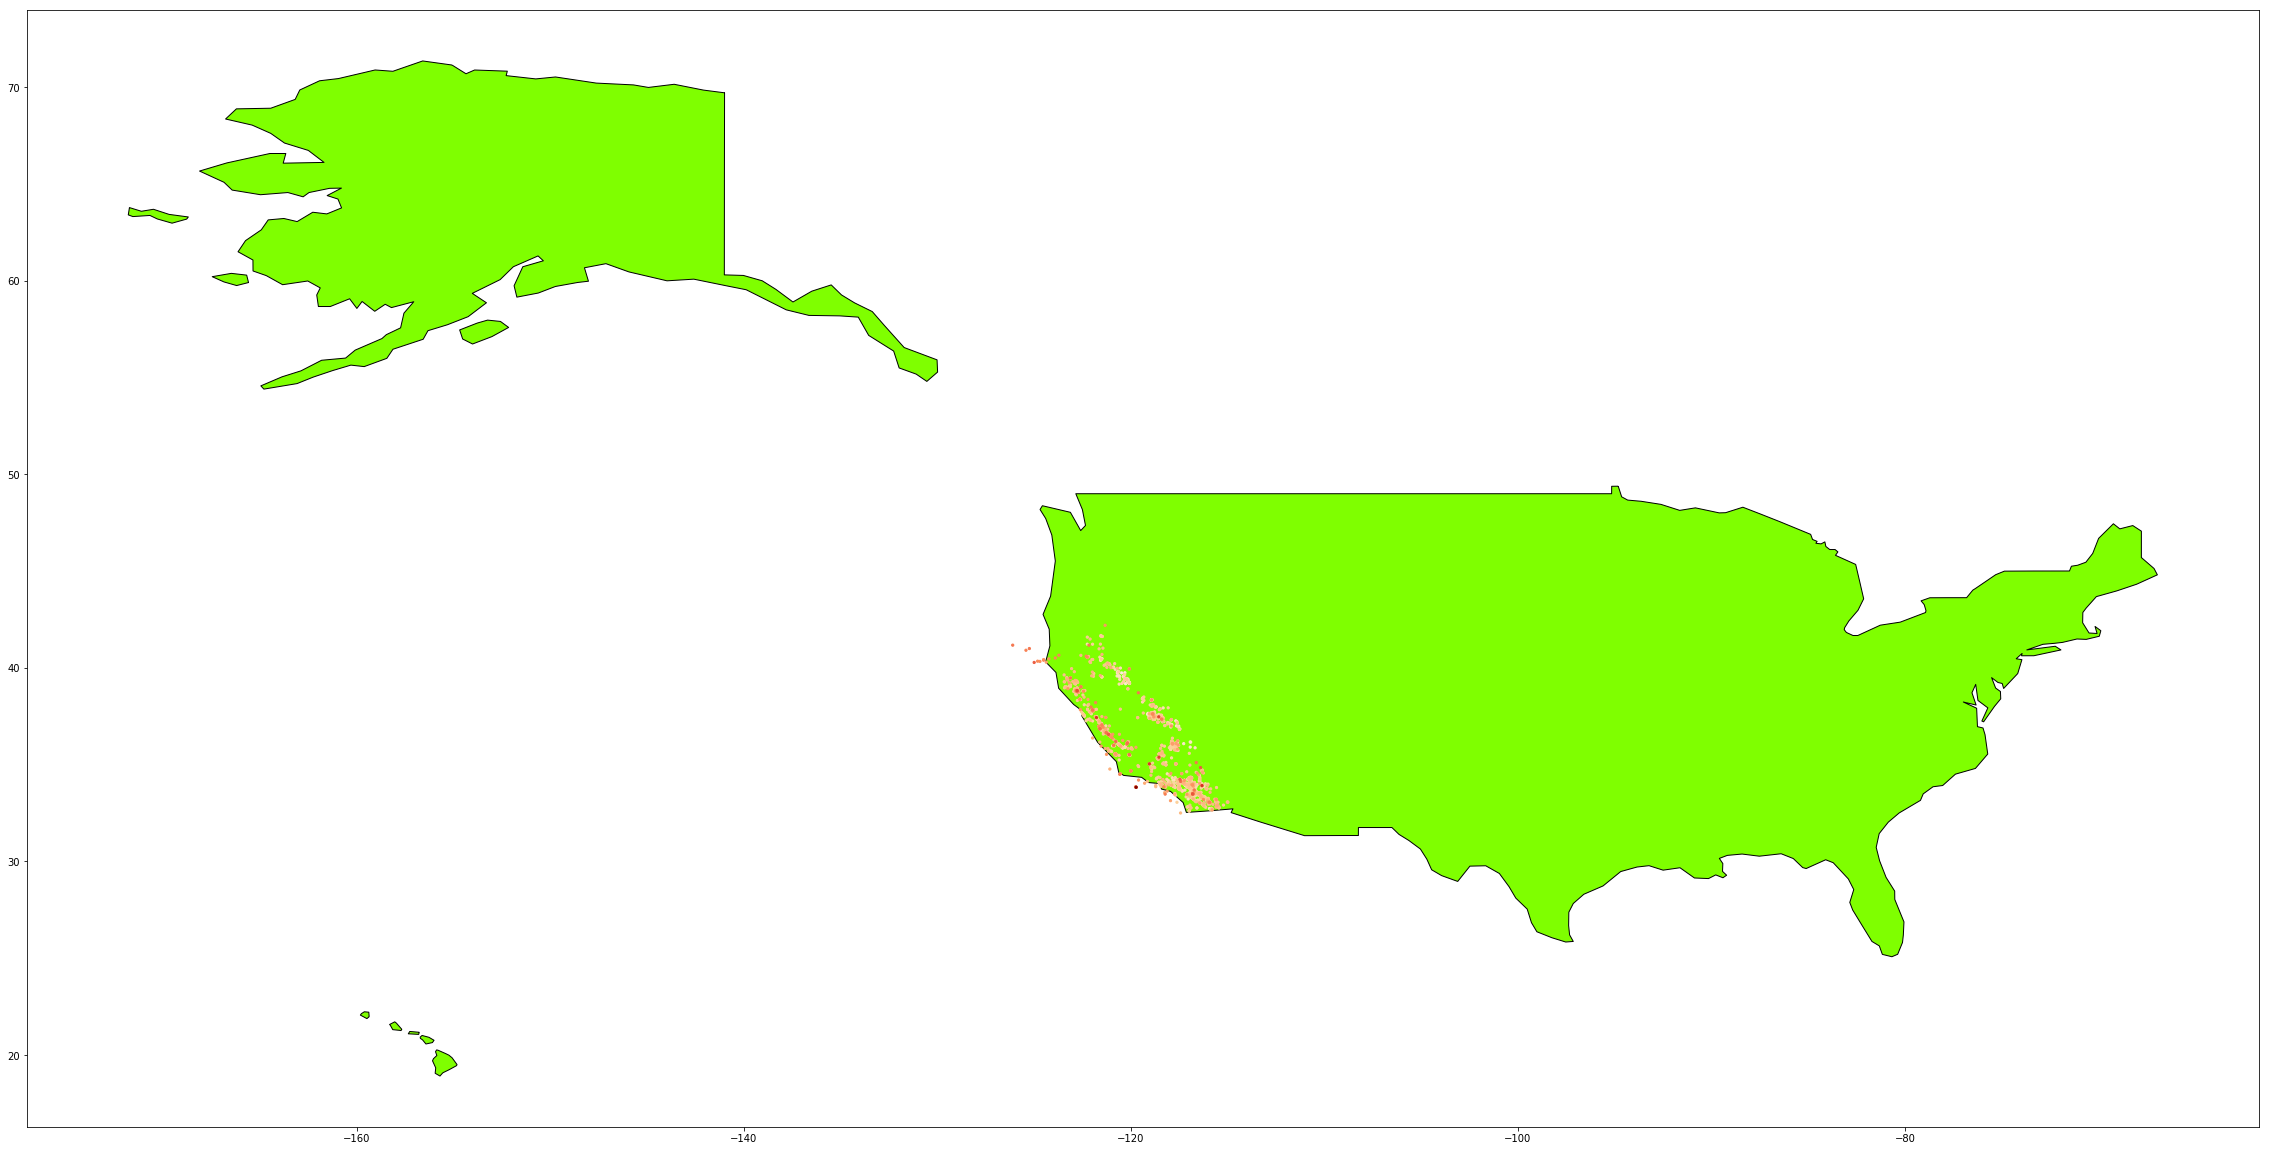

2018-03-28T06:09:34+00:00 | 6km WNW of Cobb, CA | Magnitude: -0.41
2018-03-29T12:43:39+00:00 | 3km E of Truckee, California | Magnitude: -0.3
2018-03-31T00:24:48+00:00 | 4km NNE of Truckee, California | Magnitude: -0.3
2018-04-18T05:49:52+00:00 | 2km WSW of Tahoe Vista, California | Magnitude: -0.3
2018-04-15T08:27:59+00:00 | 8km WSW of Anza, CA | Magnitude: -0.28
2018-04-02T08:16:05+00:00 | 4km NW of Anza, CA | Magnitude: -0.27
2018-04-09T22:46:36+00:00 | 1km NE of The Geysers, CA | Magnitude: -0.24
2018-04-04T01:45:26+00:00 | 11km SSW of Idyllwild, CA | Magnitude: -0.22
2018-04-05T03:39:58+00:00 | 7km ENE of Mammoth Lakes, CA | Magnitude: -0.22
2018-03-31T05:18:44+00:00 | 9km E of Mammoth Lakes, CA | Magnitude: -0.21
2018-04-21T20:53:36+00:00 | 2km ENE of The Geysers, CA | Magnitude: -0.21
2018-04-23T13:56:35+00:00 | 11km E of Mammoth Lakes, CA | Magnitude: -0.21
2018-03-26T00:33:58+00:00 | 3km W of Tahoe Vista, California | Magnitude: -0.2
2018-04-04T06:15:06+00:00 | 5km WSW of Anza

2018-04-12T09:28:11+00:00 | 9km SW of Idyllwild, CA | Magnitude: 0.49
2018-04-12T16:28:40+00:00 | 2km NNW of The Geysers, CA | Magnitude: 0.49
2018-04-14T03:39:44+00:00 | 4km W of Cobb, CA | Magnitude: 0.49
2018-04-15T02:03:22+00:00 | 10km SW of Anza, CA | Magnitude: 0.49
2018-04-15T11:39:04+00:00 | 6km NE of Anza, CA | Magnitude: 0.49
2018-04-15T11:50:13+00:00 | 10km NE of Aguanga, CA | Magnitude: 0.49
2018-04-18T08:43:18+00:00 | 7km NE of Anza, CA | Magnitude: 0.49
2018-04-18T16:55:55+00:00 | 9km NE of Aguanga, CA | Magnitude: 0.49
2018-04-19T02:47:50+00:00 | 10km NE of Aguanga, CA | Magnitude: 0.49
2018-04-20T23:09:50+00:00 | 19km ESE of Anza, CA | Magnitude: 0.49
2018-04-21T11:47:58+00:00 | 3km WNW of Anderson Springs, CA | Magnitude: 0.49
2018-04-22T20:42:54+00:00 | 2km NE of The Geysers, CA | Magnitude: 0.49
2018-04-23T17:49:16+00:00 | 3km NNW of The Geysers, CA | Magnitude: 0.49
2018-04-24T05:24:28+00:00 | 2km NW of The Geysers, CA | Magnitude: 0.49
2018-03-27T03:30:35+00:00 | 9

2018-04-11T05:22:11+00:00 | 16km WSW of Toms Place, CA | Magnitude: 0.77
2018-04-13T01:51:50+00:00 | 7km W of Cobb, CA | Magnitude: 0.77
2018-04-14T06:21:23+00:00 | 9km SW of Anza, CA | Magnitude: 0.77
2018-04-14T17:56:42+00:00 | 7km WNW of Cobb, CA | Magnitude: 0.77
2018-04-15T00:46:48+00:00 | 13km SSW of Toms Place, CA | Magnitude: 0.77
2018-04-16T01:12:42+00:00 | 2km E of Banning, CA | Magnitude: 0.77
2018-04-17T20:42:00+00:00 | 9km NE of Aguanga, CA | Magnitude: 0.77
2018-04-20T16:36:33+00:00 | 5km SSE of Home Gardens, CA | Magnitude: 0.77
2018-04-21T22:38:07+00:00 | 8km WNW of Cobb, CA | Magnitude: 0.77
2018-04-22T04:35:30+00:00 | 14km SW of Toms Place, CA | Magnitude: 0.77
2018-04-23T01:22:12+00:00 | 5km SE of Loma Linda, CA | Magnitude: 0.77
2018-04-23T13:28:59+00:00 | 14km E of Anza, CA | Magnitude: 0.77
2018-03-26T16:27:00+00:00 | 3km NW of The Geysers, CA | Magnitude: 0.78
2018-03-27T20:09:51+00:00 | 9km SSW of Idyllwild, CA | Magnitude: 0.78
2018-03-28T21:09:54+00:00 | 19km 

2018-04-03T21:11:19+00:00 | 15km E of Seven Trees, CA | Magnitude: 1.06
2018-04-06T09:55:57+00:00 | 6km NW of Julian, CA | Magnitude: 1.06
2018-04-06T10:32:34+00:00 | 20km NNW of Simmler, CA | Magnitude: 1.06
2018-04-13T22:11:56+00:00 | 19km NNW of Toms Place, CA | Magnitude: 1.06
2018-04-14T00:10:31+00:00 | 22km SSW of La Quinta, CA | Magnitude: 1.06
2018-04-17T05:10:37+00:00 | 4km W of Cobb, CA | Magnitude: 1.06
2018-04-19T03:44:30+00:00 | 7km WNW of The Geysers, CA | Magnitude: 1.06
2018-04-19T10:10:58+00:00 | 3km WNW of Cobb, CA | Magnitude: 1.06
2018-04-22T00:25:55+00:00 | 8km W of Cobb, CA | Magnitude: 1.06
2018-04-22T15:59:29+00:00 | 7km W of Cobb, CA | Magnitude: 1.06
2018-04-22T20:44:12+00:00 | 10km E of Mammoth Lakes, CA | Magnitude: 1.06
2018-04-22T22:10:53+00:00 | 20km NNW of Borrego Springs, CA | Magnitude: 1.06
2018-03-26T02:13:04+00:00 | 4km E of Banning, CA | Magnitude: 1.07
2018-03-26T18:51:57+00:00 | 11km ESE of Pinnacles, CA | Magnitude: 1.07
2018-04-04T03:47:21+00:0

2018-04-14T01:21:10+00:00 | 24km SSE of Ocotillo Wells, CA | Magnitude: 1.52
2018-04-16T05:21:56+00:00 | 3km E of Westmorland, CA | Magnitude: 1.52
2018-04-22T17:42:15+00:00 | 10km E of Mammoth Lakes, CA | Magnitude: 1.52
2018-04-22T18:52:03+00:00 | 10km ESE of Mammoth Lakes, CA | Magnitude: 1.52
2018-03-27T03:08:27+00:00 | 3km WSW of Manhattan Beach, CA | Magnitude: 1.53
2018-03-28T04:52:35+00:00 | 19km NNE of Red Bluff, CA | Magnitude: 1.53
2018-03-30T18:20:17+00:00 | 12km N of Burney, CA | Magnitude: 1.53
2018-03-30T18:28:52+00:00 | 6km NNW of Lakeside, CA | Magnitude: 1.53
2018-04-04T22:34:31+00:00 | 8km ESE of Cloverdale, CA | Magnitude: 1.53
2018-04-06T04:29:54+00:00 | 16km E of Hidden Valley Lake, CA | Magnitude: 1.53
2018-04-12T08:01:16+00:00 | 19km ENE of Lee Vining, CA | Magnitude: 1.53
2018-04-13T17:58:33+00:00 | 6km NNE of Granada Hills, CA | Magnitude: 1.53
2018-04-19T22:10:59+00:00 | 21km WSW of Wilkerson, CA | Magnitude: 1.53
2018-03-31T22:33:31+00:00 | 20km SSE of Bodie

In [44]:
import matplotlib.pyplot as plt

# store as GeoPandas DataFrame
gdf = gpd.read_file(filename)
data_size = len(gdf)
properties = list(gdf)
# print data_size
print list(gdf)
# df['type'].unique()
gdf = gdf[['time', 'place', 'mag', 'geometry']] # keep columns relevant to output
gdf_cali = gdf[gdf['place'].str.contains('California|CA')] # find entries with 'place' value containing 'California' or 'CA', 628 records
gdf_cali_sorted = gdf_cali.sort_values(['mag', 'time']) # sort by magnitude, then time occurred
# format_time = lambda x: datetime.utcfromtimestamp(x / 1000.0).strftime('%Y-%m-%dT%H:%M:%S') + '+00:00'
# gdf_cali_sorted['time'] = gdf_cali_sorted['time'].apply(format_time)

# results = []

print len(gdf_cali_sorted)

(fig, ax) = plt.subplots(figsize=(40,40))
# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['name'] == 'United States']
usa.plot(ax=ax, color='chartreuse', edgecolor='black')
gdf_cali_sorted.plot(ax=ax, column='mag', cmap='OrRd', markersize=5)

plt.show()
gdf_cali_sorted

format_time = lambda x: datetime.utcfromtimestamp(int(x) / 1000.0).strftime('%Y-%m-%dT%H:%M:%S') + '+00:00'
format_place = lambda x: str(x)
format_mag = lambda x: 'Magnitude: {}'.format(x) # better to use str.format as it converts its arguments into strings

for (index, row) in gdf_cali_sorted.iterrows():
#     record = str(row['time']) + ' | ' + str(row['place']) + ' | ' + 'Magnitude: ' + str(row['mag'])
    record = '{} | {} | {}'.format(format_time(row['time']), 
                                   format_place(row['place']), 
                                   format_mag(row['mag']))
    print record

# output format: 2017-07-13T22:32:48+00:00 | 15km SE of Mammoth Lakes, California | Magnitude: 0.92

In [42]:
from datetime import datetime

'''
# slower, time=0.00527501106262
for (i, entry) in enumerate(data['features']):
    place = entry['properties']['place']
#     cause = entry['properties']['type']
    if ('California' in place) or ('CA' in place):
#     if (('California' in place) or ('CA' in place)) and (cause == 'earthquake'):
        record = {}
        record['place'] = place
        record['time'] = entry['properties']['time']
        record['magnitude'] = entry['properties']['mag']
        cali.append(record)
        # check types above (do we still have to if we use lambda?)
'''
    
in_california = lambda x: ('California' in x['properties']['place']) or \
                          ('CA' in x['properties']['place'])
select_fields = lambda x: {'time': x['properties']['time'], 
                           'place': x['properties']['place'], 
                           'magnitude': x['properties']['mag']}

cali = filter(in_california, data['features'])
cali = map(select_fields, cali)
# faster, time = 0.00476717948914
        
print len(cali)
# print cali[0] # {'magnitude': 1.75, 'place': '5km NW of The Geysers, CA', 'time': 1524287209810}

format_time = lambda x: datetime.utcfromtimestamp(int(x) / 1000.0).strftime('%Y-%m-%dT%H:%M:%S') + '+00:00'
format_place = lambda x: str(x)
format_mag = lambda x: 'Magnitude: {}'.format(x) # better to use str.format as it converts its arguments into strings
format_output = lambda x: '{} | {} | {}'.format(format_time(x['time']), 
                                                format_place(x['place']), 
                                                format_mag(x['magnitude']))

cali_sorted = sorted(cali, key=lambda x: (x['magnitude'], x['time']))

results = map(format_output, cali_sorted)

for result in results:
    print result
    
# time 0.389930963516, faster

# output format: 2017-07-13T22:32:48+00:00 | 15km SE of Mammoth Lakes, California | Magnitude: 0.92
# time conversion function
# check data type?

3221
2018-03-28T06:09:34+00:00 | 6km WNW of Cobb, CA | Magnitude: -0.41
2018-03-29T12:43:39+00:00 | 3km E of Truckee, California | Magnitude: -0.3
2018-03-31T00:24:48+00:00 | 4km NNE of Truckee, California | Magnitude: -0.3
2018-04-18T05:49:52+00:00 | 2km WSW of Tahoe Vista, California | Magnitude: -0.3
2018-04-15T08:27:59+00:00 | 8km WSW of Anza, CA | Magnitude: -0.28
2018-04-02T08:16:05+00:00 | 4km NW of Anza, CA | Magnitude: -0.27
2018-04-15T15:06:17+00:00 | 3km SW of Anderson Springs, CA | Magnitude: -0.26
2018-04-09T22:46:36+00:00 | 1km NE of The Geysers, CA | Magnitude: -0.24
2018-04-17T01:28:31+00:00 | 2km ENE of The Geysers, CA | Magnitude: -0.24
2018-04-04T01:45:26+00:00 | 11km SSW of Idyllwild, CA | Magnitude: -0.22
2018-04-05T03:39:58+00:00 | 7km ENE of Mammoth Lakes, CA | Magnitude: -0.22
2018-03-31T05:18:44+00:00 | 9km E of Mammoth Lakes, CA | Magnitude: -0.21
2018-04-21T20:53:36+00:00 | 2km ENE of The Geysers, CA | Magnitude: -0.21
2018-04-23T13:56:35+00:00 | 11km E of Ma

2018-04-25T02:10:36+00:00 | 13km NNE of Thousand Palms, CA | Magnitude: 0.94
2018-03-30T12:49:14+00:00 | 5km NE of Running Springs, CA | Magnitude: 0.95
2018-03-31T08:12:10+00:00 | 9km SE of Valle Vista, CA | Magnitude: 0.95
2018-04-01T05:33:26+00:00 | 3km SE of San Ardo, CA | Magnitude: 0.95
2018-04-01T09:39:39+00:00 | 7km SSE of Soda Bay, CA | Magnitude: 0.95
2018-04-01T12:26:34+00:00 | 24km W of Johannesburg, CA | Magnitude: 0.95
2018-04-01T22:15:08+00:00 | 3km W of Cobb, CA | Magnitude: 0.95
2018-04-04T14:50:38+00:00 | 8km S of Idyllwild, CA | Magnitude: 0.95
2018-04-05T19:51:42+00:00 | 11km N of Borrego Springs, CA | Magnitude: 0.95
2018-04-06T12:28:17+00:00 | 6km SSE of Loma Linda, CA | Magnitude: 0.95
2018-04-09T17:03:12+00:00 | 1km WSW of Bishop, CA | Magnitude: 0.95
2018-04-11T15:01:09+00:00 | 37km N of Yucca Valley, CA | Magnitude: 0.95
2018-04-16T14:25:29+00:00 | 21km NNW of Borrego Springs, CA | Magnitude: 0.95
2018-04-19T07:07:29+00:00 | 10km NW of The Geysers, CA | Magnit

In [47]:
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from plotly.graph_objs import *

init_notebook_mode(connected=True)
mapbox_access_token = 'pk.eyJ1IjoieW91Z29lcmljIiwiYSI6ImNqZ2R4cmpsbTI3dzcycXFzdHRrdnFobGUifQ.xwe3ccbSH-QrCY9WPoYJ2w'

df = pd.io.json.json_normalize(data['features'])
df = df[['properties.time', 'properties.place', 'properties.mag', 'geometry.coordinates']] # keep columns relevant to output
df_cali = df[df['properties.place'].str.contains('California|CA')] # find entries with 'place' value containing 'California' or 'CA', 628 records
df_cali = df_cali.rename(index=str, columns={'properties.time': 'time', 'properties.place': 'place', 'properties.mag': 'mag'})
df_cali['long'] = df_cali['geometry.coordinates'].apply(lambda x: x[0])
df_cali['lat'] = df_cali['geometry.coordinates'].apply(lambda x: x[1])
df_cali = df_cali.drop(['geometry.coordinates'], axis=1)

site_lat = df_cali.lat
site_lon = df_cali.long
locations_name = df_cali.place

format_time = lambda x: datetime.utcfromtimestamp(int(x) / 1000.0).strftime('%Y-%m-%dT%H:%M:%S') + '+00:00'

df_cali_sorted = df_cali.sort_values(['mag', 'time'], ascending=True) # sort by magnitude, then time occurred
print df_cali_sorted.head()

scl = [ [0, "rgb(255, 160, 30)"], [1, "rgb(200, 0, 0)"] ]

data_cali = Data([
            Scattermapbox(
                lat = site_lat,
                lon = site_lon,
                mode = 'markers',
                marker = Marker(
                        size = 14,
                        color = df_cali['mag'],
                        colorscale = scl,
                        cmin = df_cali['mag'].min(),
                        cmax = df_cali['mag'].max(),
                        opacity = 0.8,
                        colorbar=dict(
                            title="Magnitude"
                            )
                        ),
                ),
            Scattermapbox(
                lat = site_lat,
                lon = site_lon,
                mode = 'markers',
                marker = Marker(
                    size = 6,
                    color = 'rgb(240, 200, 170)',
                    opacity = 0.5
                ),
            )]
        )
        
layout = Layout(
        title = 'Earthquake in California from Past Month',
        autosize = True,
        hovermode = 'closest',
        showlegend = False,
        mapbox = dict(
                accesstoken = mapbox_access_token,
                bearing = 0,
                center = dict(
                        lat=38,
                        lon=-98
                ),
        pitch = 0,
        zoom = 3,
        style = 'outdoors'
        ),
    )

fig = dict(data=data_cali, layout=layout)
iplot(fig, filename='Earthquake in California from Past Month')
plot(fig, filename='caliDataPlotly.html')

               time                               place   mag        long  \
9133  1522217374350                 6km WNW of Cobb, CA -0.41 -122.792667   
8698  1522327419335        3km E of Truckee, California -0.30 -120.141000   
8188  1522455888154      4km NNE of Truckee, California -0.30 -120.162800   
2048  1524030592481  2km WSW of Tahoe Vista, California -0.30 -120.081200   
2915  1523780879710                 8km WSW of Anza, CA -0.28 -116.747667   

            lat  
9133  38.835000  
8698  39.325600  
8188  39.364000  
2048  39.234200  
2915  33.518833  


'file:///Users/eric/Desktop/appl/caliDataPlotly.html'

In [14]:

in_california = lambda x: ('California' in x['properties']['place']) or \
                          ('CA' in x['properties']['place'])

cali = filter(in_california, data['features'])

for entry in cali:
    del entry['properties']['rms']
    del entry['properties']['code']
    del entry['properties']['cdi']
    del entry['properties']['sources']
    del entry['properties']['nst']
    del entry['properties']['tz']
    del entry['properties']['title']
    del entry['properties']['magType']
    del entry['properties']['detail']
    del entry['properties']['sig']
    del entry['properties']['net']
    del entry['properties']['status']
    del entry['properties']['updated']
    del entry['properties']['felt']
    del entry['properties']['alert']
    del entry['properties']['dmin']
    del entry['properties']['gap']
    del entry['properties']['types']
    del entry['properties']['url']
    del entry['properties']['ids']
    del entry['properties']['tsunami']
    del entry['properties']['mmi']

with open('cali.json', 'w') as f:
    json.dump(cali, f)

# faster, time = 0.00476717948914
        
print len(cali)
print cali[0]


3221
{u'geometry': {u'type': u'Point', u'coordinates': [-122.0886688, 39.4000015, 4.52]}, u'type': u'Feature', u'properties': {u'type': u'earthquake', u'mag': 1.78, u'place': u'16km NNE of Maxwell, CA', u'time': 1524667182790}, u'id': u'nc73005951'}
